In [1]:
import pyvisa
import datetime
import json
import time
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Connect to keithleys
rm = pyvisa.ResourceManager()
print(rm.list_resources())

csource = rm.open_resource('GPIB1::9::INSTR') #Change the number to the source you're using

print("Using " + csource.query('*IDN?'))


('TCPIP0::18.25.29.125::inst0::INSTR', 'TCPIP0::K-CX3300-ERIAL.local::hislip0::INSTR', 'TCPIP0::K-CX3300-ERIAL.local::inst0::INSTR', 'ASRL1::INSTR', 'ASRL4::INSTR', 'GPIB1::9::INSTR')
Using Keithley Instruments Inc., Model 2657A, 1409200, 1.1.8



In [65]:
# Initializes source
csource.write('smua.reset()')


14

In [107]:
# Parameters
data_dir = 'C://Users//kashkin//Desktop//keithley data//'

current_limit = 121.0e-3
voltage_limit = 20

notes = 'testing jorge stuff'
sample_name = 'sample .6 3'
data_points = 25
upper_current = 120e-3
delay_time = 1

measurement_count = 1
filter_measurement_count = 5
experiment_name = 'current up to {upper} A for {sample}'.format(upper=upper_current,sample=sample_name)
nplc = 1 # nplc/60 is the period of the measurement
input_currents = list(np.linspace(0, upper_current, num=data_points))


In [108]:
# Configure as current source
csource.write(' \
    smua.source.func = smua.OUTPUT_DCAMPS \n\
    display.smua.measure.func = display.MEASURE_DCVOLTS \n\
    smua.measure.autozero = smua.AUTOZERO_AUTO \n\
    smua.measure.autorangei = smua.AUTORANGE_OFF \n\
    smua.measure.rangei = {i_lim} \n\
    smua.measure.rangev = {v_lim} \n\
    smua.source.limiti = {i_lim} \n\
    smua.source.limitv = {v_lim} \n\
    smua.measure.adc = smua.ADC_INTEGRATE \n\
    smua.measure.nplc = {nplc} \n\
    smua.measure.delay = smua.DELAY_OFF \n\
    smua.measure.count = {m_count} \n\
    smua.measure.filter.count = {f_count} \n\
    smua.measure.filter.enable = smua.FILTER_ON \n\
    smua.measure.filter.type = smua.FILTER_REPEAT_AVG \
    '.format(i_lim = current_limit, v_lim = voltage_limit, m_count = measurement_count, nplc=nplc, f_count = filter_measurement_count))

606

In [109]:
# Blanks the data
aggregate_data = {'notes':notes,'input_currents':[],'measured_voltages':[],'measured_currents':[],'times':[]}

In [110]:
# Conduct iteration of currents
start_time = float(datetime.datetime.now().timestamp())
for current in input_currents:
    csource.write('smua.source.leveli = %s'%current)

    csource.write('ireading, vreading = smua.measure.iv(smua.nvbuffer1, smua.nvbuffer2)')

    measured_current = float(csource.query("print(ireading)")[:-1])
    measured_voltage = float(csource.query("print(vreading)")[:-1])

    aggregate_data['input_currents'].append(current)
    aggregate_data['measured_voltages'].append(measured_voltage)
    aggregate_data['measured_currents'].append(measured_current)
    aggregate_data['times'].append(float(datetime.datetime.now().timestamp()) - start_time)
    time.sleep(delay_time)

csource.write('smua.source.leveli = 0')


24

In [116]:
# dts = []
# for i in range(len(aggregate_data['times']) - 1):
#     dts.append(aggregate_data['times'][i+1] - aggregate_data['times'][i])
# print(np.average(dts))
# print(1/np.average(dts))
# plt.hist(dts)

In [113]:
# Saves the data
filename = data_dir + experiment_name + '_ %s'%datetime.datetime.now().strftime('%Y_%m_%d-%H_%M_%S') + '.json'

with open(filename, 'w') as file:
    json.dump(aggregate_data, file)

print('saved to %s' %{filename})

saved to {'C://Users//kashkin//Desktop//keithley data//current up to 0.12 A for sample .6 3_ 2022_11_23-18_43_50.json'}


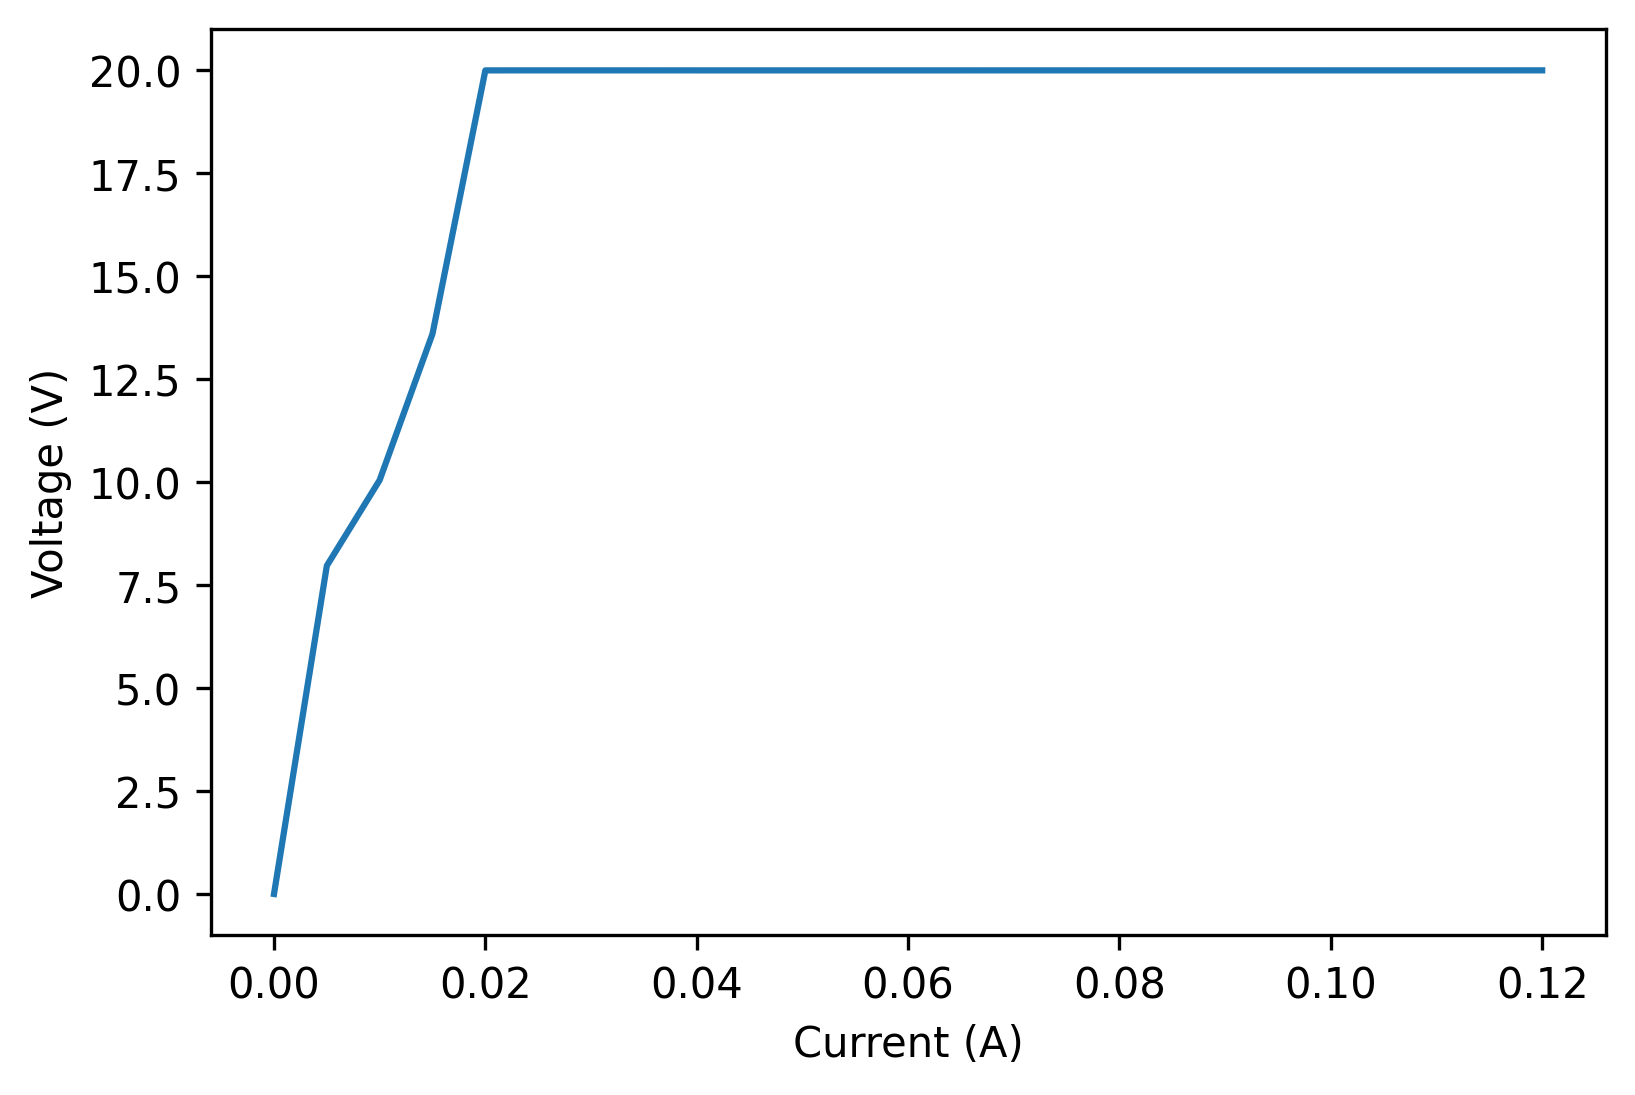

In [114]:
plt.figure(dpi=300)
input_currents = aggregate_data['input_currents']
measured_voltages = aggregate_data['measured_voltages']
plt.plot(input_currents, measured_voltages)

plt.xlabel('Current (A)')
plt.ylabel('Voltage (V)')
plt.show()

In [115]:
#Turn off output and drain capacitors
print("\nSetting source voltage to 0 V")
csource.write("smua.source.levelv = 0")

print("Turning off output")
csource.write("smua.source.output = 0")

print("Closing Keithley connection")
csource.close()



Setting source voltage to 0 V
Turning off output
Closing Keithley connection
